In [2]:
import numpy as np
import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

from stepbystep.v0 import StepByStep

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')


In [3]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)
print(X.shape, y.shape)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

(100, 2) (100,)


In [4]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

In [5]:
torch.manual_seed(13)

# 从Numpy数据构建的张量
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# 构建包含所有数据点的数据集
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# 构建每个集合的加载器
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [8]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# 正类
positive_pred = dummy_predictions[dummy_labels == 1]
first_summation = torch.log(positive_pred).sum()
print(positive_pred, first_summation)

# 负类
negative_pred = dummy_predictions[dummy_labels == 0]
second_summation = torch.log(1 - negative_pred).sum()
print(negative_pred, second_summation)

n_total = dummy_labels.size(0)

loss = -(first_summation + second_summation) / n_total
loss

tensor([0.9000]) tensor(-0.1054)
tensor([0.2000]) tensor(-0.2231)


tensor(0.1643)

In [11]:
logit1 = torch.log(torch.tensor([0.9/0.1]))
logit2 = torch.log(torch.tensor([0.2/0.8]))

In [12]:
dummy_imb_labels = torch.tensor([1.0, 0, 0, 0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])
dummy_imb_labels, dummy_imb_logits

(tensor([1., 0., 0., 0.]), tensor([ 2.1972, -1.3863, -1.3863, -1.3863]))

In [13]:
n_neg = (dummy_imb_labels == 0).sum().float()
n_pos = (dummy_imb_labels == 1).sum().float()

pos_weight = (n_neg / n_pos).view(1,)
pos_weight

tensor([3.])

In [16]:
loss_fn_imb = nn.BCEWithLogitsLoss(
    reduction='mean',
    pos_weight=pos_weight
)

loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)
loss

tensor(0.2464)

In [17]:
loss_fn_imb2 = nn.BCEWithLogitsLoss(
    reduction='sum',
    pos_weight=pos_weight
)

loss = loss_fn_imb2(dummy_imb_logits, dummy_imb_labels)
loss = loss / (pos_weight * n_pos + n_neg)
loss

tensor([0.1643])

In [18]:
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module("linear", nn.Linear(2, 1))

optimizer = optim.SGD(model.parameters(), lr=lr)

loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

In [19]:
sbs = StepByStep(model=model, loss_fn=loss_fn, optimizer=optimizer)
sbs.set_loaders(train_loader, val_loader)

sbs.train(n_epochs=200)

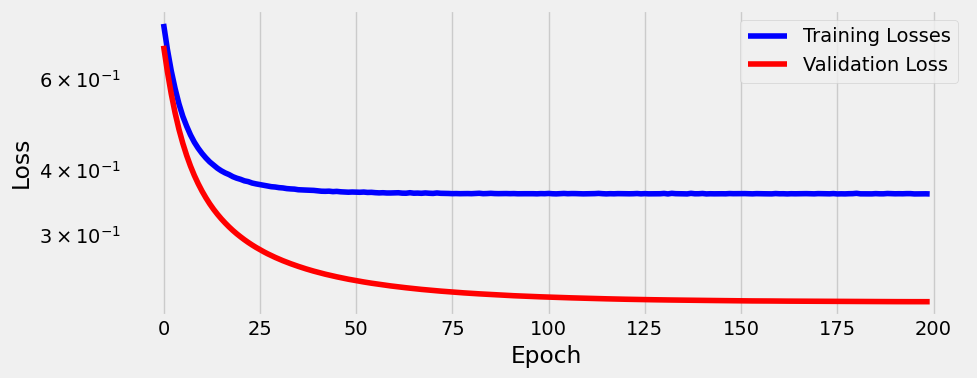

In [20]:
fig = sbs.plot_losses()

In [21]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.2038, -1.9279]])), ('linear.bias', tensor([-0.0642]))])
